# Inversion of DC & IP data at the Century Deposit

The Century Deposit is a Zinc-lead-silver deposit located 250 km to the NNW of the Mt Isa region in Queensland Australia (Location: 18° 43' 15"S, 138° 35' 54"E). 

<img src="./images/Mutton-Figure1-1.png" width=45%>


**References**
- [Mutton (2000)](https://doi.org/10.1190/1.1444878)

- [geologic background](http://www.portergeo.com.au/database/mineinfo.asp?mineid=mn075)

For background on DC Resistivity Surveys, see [GPG: DC Resistivity](https://gpg.geosci.xyz/content/DC_resistivity/index.html)

In this notebook, we are going to invert the data and see if we can replicate the results presented in [Mutton, 2000](https://doi.org/10.1190/1.1444878). Specifically, we will work with data collected along the line 46800mE. 


## Motivation: replicate inversion results from 20 years ago!

<img src="images/Mutton-Figure2-1.png" width=70%>

The image below shows the Induced Polarization inversion result generated using the UBC 2D DCIP inversion code that was published in [Mutton, 2000](https://doi.org/10.1190/1.1444878). 

**Can we replicate it with SimPEG?** 

(and update the colorbar 😉)

<img src="images/Mutton-Figure5-1.png" width=80%>

## Step 0: Import Dependencies

Here are links to the documentation for each of the packages we rely on for this tutorial. 

**Core Python / Jupyter**
- [numpy](https://numpy.org/doc/1.18/): arrays
- [matplotlib](https://matplotlib.org/3.2.1/contents.html): plotting
- [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/index.html): interactive widgets in jupyter

**SimPEG ecosystem**
- [discretize](http://discretize.simpeg.xyz/): meshes and differential operators 
- [pymatsolver](http://pymatsolver.rtfd.io/): wrappers on linear solvers
- [SimPEG](http://docs.simpeg.xyz/): Simulation and Parameter Estimation in Geophysics

In [1]:
# core python 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import ipywidgets
import os

# tools in the simPEG Ecosystem 
import discretize  # for creating computational meshes

# linear solvers
try: 
    from pymatsolver import Pardiso as Solver  # this is a fast linear solver 
except ImportError:
    from SimPEG import SolverLU as Solver  # this will be slower

# SimPEG inversion machinery
from SimPEG import (
    Data, maps,
    data_misfit, regularization, optimization, inverse_problem, 
    inversion, directives
) 

# DC resistivity and IP modules
from SimPEG.electromagnetics import resistivity as dc
from SimPEG.electromagnetics import induced_polarization as ip
from SimPEG.electromagnetics.static import utils as dc_utils

In [2]:
# set the font size in the plots
import matplotlib as mpl
mpl.rcParams.update({"font.size": 8})
plt.rcParams["font.family"] = "Arial"

In [3]:
try:
    verbose = childnb_verbose
except:
    verbose = True

## Step 1: Load the data


**What are our data?**

The survey collected at the Century Deposit uses a dipole-dipole geometry with:
- Current Electrodes (A, B): we refer to the source electrodes as "A" for the positive electrode and "B" for the negative electrode. 
- Potential Electrodes (M, N): we refer to the positive potential electrode as "M" and the negative as "N".

A datum is the potential difference between the M and N electrodes. 

<img src="https://gpg.geosci.xyz/_images/add1.gif">

<img src="https://gpg.geosci.xyz/_images/add2.gif">

The data are stored in the `century` directory. Here, we take a look at what is in that directory. Each folder contains data associated with the named line. 

In [4]:
if verbose:
    print(os.listdir('century'))

['27750N', '46200E', '46800E', '47000E', '47200E', '47700E', 'Data_in_3D_format', 'geologic_section.csv', 'gmt']


We will focus on the `46800E` line. In that directory, there are several files. The `.OBS` files are the observed data. The other files are previous inversion results from the UBC inversion. For the two `.OBS` files: `POT` referrs to "Potentials" - these are our DC data and `IP` referrs to "Induced Polarization". We will start by working with the DC resistivity data and so will load up that file first. 

In [5]:
line = "46800E"
if verbose:
    print(os.listdir(os.path.join('century',line)))

dc_data_file = f"./century/{line}/{line[:-1]}POT.OBS"

['46800IP.OBS', '46800POT.OBS', '468MESH.DAT', 'DCMODA.CON', 'DCMODA.PRE', 'IPMODA.CHG', 'IPMODA.PRE']


These file formats are an older version of the UBC DC format and are very similar to the current [UBC DC IP Surface Format](https://giftoolscookbook.readthedocs.io/en/latest/content/fileFormats/dcip2dObsfile.html#surface-format)

```
Comment line: description of data
   n_sources dipole(1) dipole(1) 
     A_location  B_location   n_receivers
   M_location  N_location  measured_potential  standard_deviation
   M_location  N_location  measured_potential  standard_deviation
     A_location  B_location   n_receivers
   M_location  N_location  measured_potential  standard_deviation
   M_location  N_location  measured_potential  standard_deviation
   ....
```

In [6]:
if verbose:
    with open(dc_data_file) as f:
        print(f.read())

AVG-GDAT 1.22: CENTURY Converted by RES2POT to conductivitie
   27    1    1
    26000.000000    26100.000000           2
   26700.0   26800.0   -.00127    .00006
   26800.0   26900.0   -.00080    .00004
    26100.000000    26200.000000           3
   26700.0   26800.0   -.00164    .00008
   26800.0   26900.0   -.00099    .00005
   26900.0   27000.0   -.00063    .00003
    26200.000000    26300.000000           4
   26700.0   26800.0   -.00252    .00013
   26800.0   26900.0   -.00146    .00007
   26900.0   27000.0   -.00088    .00004
   27000.0   27100.0   -.00125    .00006
    26300.000000    26400.000000           5
   26700.0   26800.0   -.00504    .00025
   26800.0   26900.0   -.00260    .00013
   26900.0   27000.0   -.00147    .00007
   27000.0   27100.0   -.00195    .00010
   27100.0   27200.0   -.00103    .00005
    26400.000000    26500.000000           6
   26700.0   26800.0   -.01048    .00052
   26800.0   26900.0   -.00472    .00024
   26900.0   27000.0   -.00249    .00012
 

Next, we write a function to read in these data. Within SimPEG, there are lots of utilities for reading in data, particularly if they are in common formats such as the more recent UBC formats (e.g. see `dc.utils.readUBC_DC2Dpre`). 

In [7]:
def read_dcip_data(filename, verbose=True):
    """
    Read in a .OBS file from the Century data set into a python dictionary. 
    The format is the old UBC-GIF DCIP format.
    
    Parameters
    ----------
    filename : str
        Path to the file to be parsed
    
    verbose: bool
        Print some things? 
    
    
    Returns
    -------
    dict
        A dictionary with the locations of
        - a_locations: the positive source electrode locations (numpy array) 
        - b_locations: the negative source electrode locations (numpy array) 
        - m_locations: the receiver locations (list of numpy arrays)
        - n_locations: the receiver locations (list of numpy arrays)
        - observed_data: observed data (list of numpy arrays)
        - standard_deviations: assigned standard deviations (list of numpy arrays)
        - n_sources: number of sources (int)
    
    """
    
    # read in the text file as a numpy array of strings (each row is an entry)
    contents = np.genfromtxt(filename, delimiter=' \n', dtype="U")
    
    # the second line has the number of sources, current, and data type (voltages if 1)
    n_sources = int(contents[1].split()[0])
    
    if verbose is True: 
        print(f"number of sources: {n_sources}")
    
    # initialize storage for the electrode locations and data
    a_locations = np.zeros(n_sources)
    b_locations = np.zeros(n_sources)
    m_locations = []
    n_locations = []
    observed_data = []
    standard_deviations = []
    
    # index to track where we have read in content 
    content_index = 1 
    
    # loop over sources 
    for i in range(n_sources):
        # start by reading in the source info 
        content_index = content_index + 1  # read the next line
        a_location, b_location, nrx = contents[content_index].split()  # this is a string

        # convert the strings to a float for locations and an int for the number of receivers
        a_locations[i] = float(a_location)
        b_locations[i] = float(b_location)
        nrx = int(nrx)

        if verbose is True: 
            print(f"Source {i}: A-loc: {a_location}, B-loc: {b_location}, N receivers: {nrx}")

        # initialize space for receiver locations, observed data associated with this source
        m_locations_i, n_locations_i = np.zeros(nrx), np.zeros(nrx)
        observed_data_i, standard_deviations_i = np.zeros(nrx), np.zeros(nrx)

        # read in the receiver info 
        for j in range(nrx):
            content_index = content_index + 1  # read the next line
            m_location, n_location, datum, std = contents[content_index].split()

            # convert the locations and data to floats, and store them
            m_locations_i[j] = float(m_location)
            n_locations_i[j] = float(n_location)
            observed_data_i[j] = float(datum)
            standard_deviations_i[j] = float(std)

        # append the receiver info to the lists
        m_locations.append(m_locations_i)
        n_locations.append(n_locations_i)
        observed_data.append(observed_data_i)
        standard_deviations.append(standard_deviations_i)
    
    return {
        "a_locations": a_locations,
        "b_locations": b_locations, 
        "m_locations": m_locations,
        "n_locations": n_locations,
        "observed_data": observed_data, 
        "standard_deviations": standard_deviations,
        "n_sources": n_sources, 
    }

In [8]:
dc_data_dict = read_dcip_data(dc_data_file, verbose=verbose)

number of sources: 27
Source 0: A-loc: 26000.000000, B-loc: 26100.000000, N receivers: 2
Source 1: A-loc: 26100.000000, B-loc: 26200.000000, N receivers: 3
Source 2: A-loc: 26200.000000, B-loc: 26300.000000, N receivers: 4
Source 3: A-loc: 26300.000000, B-loc: 26400.000000, N receivers: 5
Source 4: A-loc: 26400.000000, B-loc: 26500.000000, N receivers: 6
Source 5: A-loc: 26500.000000, B-loc: 26600.000000, N receivers: 7
Source 6: A-loc: 26600.000000, B-loc: 26700.000000, N receivers: 7
Source 7: A-loc: 26700.000000, B-loc: 26800.000000, N receivers: 6
Source 8: A-loc: 26800.000000, B-loc: 26900.000000, N receivers: 6
Source 9: A-loc: 26900.000000, B-loc: 27000.000000, N receivers: 6
Source 10: A-loc: 27000.000000, B-loc: 27100.000000, N receivers: 6
Source 11: A-loc: 27100.000000, B-loc: 27200.000000, N receivers: 6
Source 12: A-loc: 27200.000000, B-loc: 27300.000000, N receivers: 6
Source 13: A-loc: 27300.000000, B-loc: 27400.000000, N receivers: 6
Source 14: A-loc: 27400.000000, B-lo

In [9]:
if verbose:
    for key, value in dc_data_dict.items():
        print(f"{key:<20}: {type(value)}")

a_locations         : <class 'numpy.ndarray'>
b_locations         : <class 'numpy.ndarray'>
m_locations         : <class 'list'>
n_locations         : <class 'list'>
observed_data       : <class 'list'>
standard_deviations : <class 'list'>
n_sources           : <class 'int'>


In [10]:
if verbose:
    print(dc_data_dict["a_locations"])

[26000. 26100. 26200. 26300. 26400. 26500. 26600. 26700. 26800. 26900.
 27000. 27100. 27200. 27300. 27400. 27500. 27600. 27700. 27800. 27900.
 28000. 28100. 28200. 28300. 28400. 28500. 28600.]


At this point, we have not used anything in SimPEG, this is all pure python. Now, we will look at using SimPEG. 

## Step 2: Create a SimPEG survey

In SimPEG, the `survey` object keeps track of the geometry and type of sources and receivers.  Similar to the way the data file was structured, each `source` takes a `receiver_list` which knows about the different receiver types that are "listening" to that source. 

For example, for the first source, we have dipole receivers at 2 different locations. A SimPEG receiver object can have multiple locations, so conceptually, we can think of a receiver object containing all receivers of one type. If we also had a pole-source, then we would add another receiver type to our receiver list. Since we will run 2D simulations and inversions, then the receivers need to be defined in 2D space `[x, z]`. The receivers are on the surface of the Earth, and in this example, we will not consider topography, so they are at `z=0`.

```python

m_locs = np.array([
    [26700.0, 0.],
    [26800.0, 0.]
])

n_locs = np.array([
    [26800.0, 0.],
    [26900.0, 0.]
])

rx = dc.receivers.Dipole(locations_m=m_locs, locations_n=n_locs) 
rx_list = [rx]

```

Note that in SimPEG, we use column-major / Fortran ordering. So `m_locs[:, 0]` corresponds to all of the x-locations and `m_locs[:, 1]` corresponds to all of the z-locations.  

A source in SimPEG has a single location. For the first source: 
```python 

a_loc = np.r_[26000.0, 0.]
b_loc = np.r_[26100.0, 0.]

src = dc.sources.Dipole(location_a=a_loc, location_b=b_loc, receiver_list=rx_list)
```

Finally, the survey is instantiated with a source list which contains all of the sources and their associated receiver lists
```python
survey = dc.Survey(source_list=[src1, src2, ...])
```

In [11]:
# initialize an empty list for each 
source_list = []

for i in range(dc_data_dict["n_sources"]):
    
    # receiver electrode locations in 2D 
    m_locs = np.vstack([
        dc_data_dict["m_locations"][i], 
        np.zeros_like(dc_data_dict["m_locations"][i])
    ]).T
    n_locs = np.vstack([
        dc_data_dict["n_locations"][i],
        np.zeros_like(dc_data_dict["n_locations"][i])
    ]).T
    
    # construct the receiver object 
    receivers = dc.receivers.Dipole(locations_m=m_locs, locations_n=n_locs)
    
    # construct the source 
    source = dc.sources.Dipole(
        location_a=np.r_[dc_data_dict["a_locations"][i], 0.],
        location_b=np.r_[dc_data_dict["b_locations"][i], 0.],
        receiver_list=[receivers]
    )

    
    # append the new source to the source list
    source_list.append(source)

In [12]:
survey = dc.Survey(source_list=source_list)

### Observed Data 

The data object keeps track of our observed data, the uncertainties and the survey parameters corresponding to each datum. The order of the data and standard deviations should be identical to how we would unwrap the source and receiver lists. E.g.

```
dobs = [d(source1, receiver1), d(source1, receiver2), d(source2, receiver1), ...]
```

Since this is exactly the same order as how we read the data in, we can simply concatenate the data in our dictionary. 

In [13]:
dc_data = Data(survey, 
    dobs=np.hstack(dc_data_dict["observed_data"]),
    standard_deviation=np.hstack(dc_data_dict["standard_deviations"])
)

### Visualizing data in a Pseudosection

Pseudosections give us a way to visualize a profile of DC resistivity or IP data. The horizontal location is the mid-point between the center of the source AB electrodes and the MN electrodes. The vertical location corresponds to the "n-spacing" which is the separation distance between the AB and MN electrodes divided by the length of the AB / MN dipoles. For this survey, the dipole length is 100m, so an n-spacing of 2 corresponds to a distance of 200m between the midpoints of the AB and MN electrodes. 

C:\Users\dwill\AppData\Local\Temp\ipykernel_27768\534921115.py:5: UserWarning: plot_pseudosection unused kwargs: ['data_location']
  ax = dc_utils.plot_pseudosection(
C:\Users\dwill\AppData\Local\Temp\ipykernel_27768\534921115.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


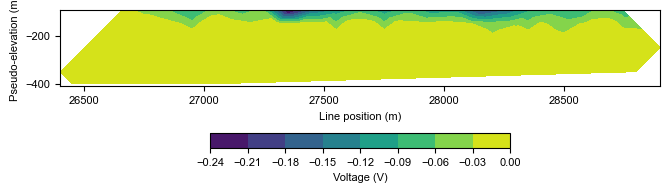

In [14]:
if verbose:
    # plot pseudosection
    fig = plt.figure(figsize=(8, 6))
    ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
    ax = dc_utils.plot_pseudosection(
        dc_data, data_type="potential",
        plot_type="contourf", 
        ax=ax1,
        data_location=True,
        cbar_label="Voltage (V)",
        create_colorbar=False
    )
    ax[0].set_aspect(1)
    fig.colorbar(ax[1], orientation='horizontal', shrink=0.5, pad=0.1, label='Voltage (V)')
    plt.tight_layout()
    plt.savefig('century_data.png', dpi=600, bbox_inches='tight')

In [15]:
def plot_building_pseudosection(source_ind=0):
    """
    A plotting function to visualize how a pseudosection is built up. 
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    cc = dc_utils.pseudo_locations(dc_data.survey)
    mid_x = cc[:,0]
    mid_z = cc[:,1]
    ax.plot(mid_x, mid_z, '.k', alpha=0.5)
    
    # plot the source location
    a_loc = dc_data_dict["a_locations"][source_ind]
    b_loc = dc_data_dict["b_locations"][source_ind]
    src_mid = (a_loc+b_loc)/2
    ax.plot(np.r_[a_loc, b_loc], np.r_[0, 0], 'C0.')
    ax.plot(src_mid, np.r_[0], 'C0x', ms=6)

    # plot the receiver locations
    m_locs = dc_data_dict["m_locations"][source_ind]
    n_locs = dc_data_dict["n_locations"][source_ind]
    rx_mid = (m_locs+n_locs)/2
    ax.plot(np.r_[m_locs, n_locs], np.zeros(2*len(m_locs)), 'C1.')
    ax.plot(rx_mid, np.zeros_like(m_locs), 'C1x', ms=6)
    
    # plot where the pseudosection points should be 
    pseudo_x = (rx_mid + src_mid)/2.
    pseudo_z = -np.abs(rx_mid-src_mid)/2.
    
    ax.plot(np.r_[src_mid, pseudo_x], np.r_[0, pseudo_z], '-k', alpha=0.3)
    
    # draw lines to the points we are plotting
    for rx_x, px, pz in zip(rx_mid, pseudo_x, pseudo_z): 
        ax.plot(np.r_[px, rx_x], np.r_[pz, 0], '-k', alpha=0.3)
    
    # these are the data corresponding to the source-receiver pairs we are looking at
    ax.plot(pseudo_x, pseudo_z, 'C2o')
    ax.set_xlabel("Northing (m)")
    ax.set_ylabel("n-spacing")
    
    ax.set_yticklabels([])
    ax.set_xlim([25900, 29300])
    ax.set_aspect(1.5) 
    

In [16]:
if verbose:
    ipywidgets.interact(
        plot_building_pseudosection, 
        source_ind=ipywidgets.IntSlider(min=0, max=int(dc_data_dict["n_sources"])-1, value=0)
    )

interactive(children=(IntSlider(value=0, description='source_ind', max=26), Output()), _dom_classes=('widget-i…

### Apparent resistivity

Our measured data are potential differences in units of volts. Both the geometry of the sources and receivers, as well as the geology, influence these values. Having both of these factors influence the values can make it challenging to make sense of the data. In order to translate them to something more interpretable, it is common to work with apparent resistivity values, which are derived by considering the potentials that would be measured if the earth were a half-space: 

$$
\rho_a = \frac{2 \pi \Delta V}{IG}
$$

Where:
- $\rho_a$ is the apparent resistivity ($\Omega$ m)
- $\Delta V$ is the measured potential difference (V)
- $I$ is the source current (A)
- $G$ is the geometric factor which depends on the location of all four electrodes. 
    $$
    G = \left(\frac{1}{r_{AM}} - \frac{1}{r_{BM}} - \frac{1}{r_{AN}} + \frac{1}{r_{BN}} \right)
    $$

Pseudosections of the apparent resistivity are a valuable tool for QC'ing and processing the data. It is easier to spot outliers and see trends in the data than using plots of the potentials.

In [ ]:
if verbose:
    # plot pseudosection
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    dc_utils.plot_pseudosection(
        dc_data, data_type="apparent resistivity", 
        plot_type="contourf", data_location=True, ax=ax, cbar_opts={"pad":0.25}
    )
    ax.set_aspect(1.5)  # some vertical exxageration
    ax.set_title(f"DC: {line} Pseudosection")
    ax.set_xlabel("Northing (m)")

### Histogram of our data

In addition to looking at a 2D pseudosection of the data, a histogram gives us an idea of the distribution of apparent resistivities. For more complex survey geometries (e.g. fully 3D), it is not always clear how to plot data in a pseudosection form, so histograms are a valueable tool for visualizing data and estimating a good background resistivity for the starting and reference models. 

In [17]:
apparent_resistivity = dc_utils.apparent_resistivity_from_voltage(dc_data.survey, dc_data.dobs)

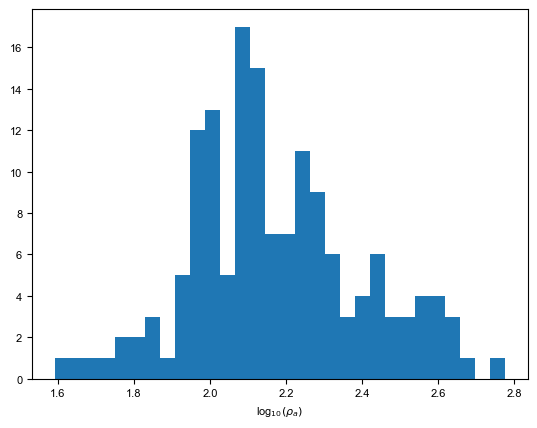

In [18]:
if verbose:
    fig, ax = plt.subplots(1, 1)
    out = ax.hist(np.log10(apparent_resistivity), bins=30)
    ax.set_xlabel("log$_{10}(\\rho_a)$")

estimate a background model 

In [19]:
# rho0 = 10**np.mean(np.log10(apparent_resistivity))
rho0 = np.median(apparent_resistivity)
if verbose:
    print(rho0)

135.90619481429147


# Step 3: set up the forward simulation machinery

### The DC resistivity equations
Now that we have a sense of our data, we will set up a forward simulation which is responsible for simulating predicted data given a model. 

The equations we are solving are the steady-state Maxwell's equations: 

$$
\nabla \times \vec{e} = 0 \quad \to \quad \vec{e} = -\nabla \phi \\
\nabla \cdot \vec{j} = - \nabla \cdot \vec{j}_s = I \delta(r)
$$

Since the curl of the electric field is zero, we can represent it as a the gradient of a scalar potential $\phi$.

Ohm's law relates the current density to the electric field through the resistivity, $\rho$, in units of $\Omega$m (or equivalently through the electrical conductivity $\sigma = 1/\rho$.  

$$
\vec{j} = \frac{1}{\rho} \vec{e}
$$

and assembling everything

$$
\nabla \cdot \frac{1}{\rho} \nabla \phi = I \delta(r) 
$$

### Discretizing

In SimPEG, we use a Finite Volume approach to solving this partial differential equation (PDE). To do so, we define where each component of the equation lives on the mesh. Scalars can either be defined at cell centers or on nodes whereas vectors are defined on cell faces or edges. There are two discretizations implemented in SimPEG for the DC resistivity problem: Cell-Centered and Nodal. In both, we discretize physical properties (resistivity) at cell centers, and you can think of the resistivity filling that entire "lego-block". The difference between the two discretizations depends upon where we discretize the potential $\phi$: either at the cell centers or the nodes. For this tutorial, we will use the **Nodal discretization** where
- $\rho$: discretized at cell centers
- $\phi$: discretized at nodes
- $\vec{e}$: discretized on cell edges

<img src="images/finite-volume-02.png" width=25%>

We will not go into the details here, but we highlight the importance of the boundary conditions. The Nodal discretization uses Neumann boundary conditions, which means that there is no flux of current through the boundary. Thus when we design our mesh, it needs to extend sufficiently far as to satisfy this condition. 

$$
\frac{1}{\rho}\vec{e} = 0 | \partial\Omega
$$



For an overview of the derivation for the cell centered discretization, see the leading edge article [_Pixels and their Neighbors_](https://github.com/simpeg/tle-finitevolume/blob/master/Pixels_and_neighbors.pdf). 





### 3.1 Design a Mesh

When designing a mesh, there are 3 main items to consider
- minimum cell size: 
    - controls resolution 
    - typically ~4 per minimum electrode spacing
    
    
- extent of the core domain:  
    - in the horizontal dimension: typically use the extent of the survey (or slightly beyond)
    - in the vertical direction, we want the core region to extend to the depth to which we are sensitive to variations in physical properties. As a rule of thumb, this is typically a fraction of the maximum source-receiver separation
    
    
- extent of the full modelling domain: 
   - need to satisfy boundary conditions! 
   - typically add ~the maximum source-receiver separation in each dimension
   

Here, we will use a `TensorMesh`, where each dimension can be defined with just a cell width. 
A tensor in each dimension is enough to define the entire mesh.
For larger domains, we recommend using an `TreeMesh`. There are [examples in the discretize documentation](http://discretize.simpeg.xyz/en/master/tutorials/mesh_generation/4_tree_mesh.html) for creating QuadTree (2D) and OcTree (3D) meshes. 

In [20]:
min_electrode_spacing = np.min(np.abs(survey.locations_a[:, 0] - survey.locations_b[:, 0]))
n_cells_per_spacing = 4

dx = min_electrode_spacing / n_cells_per_spacing
dz = min_electrode_spacing / n_cells_per_spacing

if verbose:
    print(
        f"We will use a base mesh with {dx} m x {dz} m cells"
    )

We will use a base mesh with 25.0 m x 25.0 m cells


In [21]:
#core_domain_x = np.r_[
#    survey.electrode_locations[:, 0].min(),
#    survey.electrode_locations[:, 0].max()
#]
electrode_locations = np.c_[
    survey.locations_a,
    survey.locations_b,
    survey.locations_m,
    survey.locations_n,
]

unique_locations = np.unique(
    np.reshape(electrode_locations, (4 * survey.nD, 2)), axis=0
)

core_domain_x = np.r_[
    unique_locations[:,0].min(),
    unique_locations[:,0].max()
]

if verbose:
    print(core_domain_x)

[26000. 29200.]


In [22]:
# find the maximum spacing between source, receiver midpoints
mid_ab = (survey.locations_a + survey.locations_b)/2
mid_mn = (survey.locations_m + survey.locations_n)/2
separation_ab_mn = np.abs(mid_ab - mid_mn)
max_separation = separation_ab_mn.max()
print(f"The maximum separation is {max_separation}m")

core_domain_z = np.r_[-max_separation/3., 0.]
if verbose:
    print(core_domain_z)

The maximum separation is 800.0m
[-266.66666667    0.        ]


In [23]:
n_core_extra = 4 
n_core_x = np.ceil(np.diff(core_domain_x)/dx) + n_core_extra*2  # on each side
n_core_z = np.ceil(np.diff(core_domain_z)/dz) + n_core_extra  # just below

padding_factor = 1.3
n_pad_x = 10
n_pad_z = 10

In [24]:
hx = [(dx, n_pad_x, -padding_factor), (dx, n_core_x), (dx, n_pad_x, padding_factor)]
hz = [(dz, n_pad_z, -padding_factor), (dz, n_core_z)]

mesh = discretize.TensorMesh([hx, hz])

# origin of the mesh
mesh_hx = mesh.h[0]
mesh_hy = mesh.h[1]
mesh.x0 = np.r_[
    -mesh_hx[:n_pad_x + n_core_extra].sum() + core_domain_x.min(),
    -mesh_hy.sum()
]

if verbose:
    mesh

C:\Users\dwill\AppData\Local\Temp\ipykernel_27768\421519130.py:3: FutureWarning: TensorMesh.plotGrid has been deprecated, please use TensorMesh.plot_grid. It will be removed in version 1.0.0 of discretize.
  mesh.plotGrid(ax=ax)


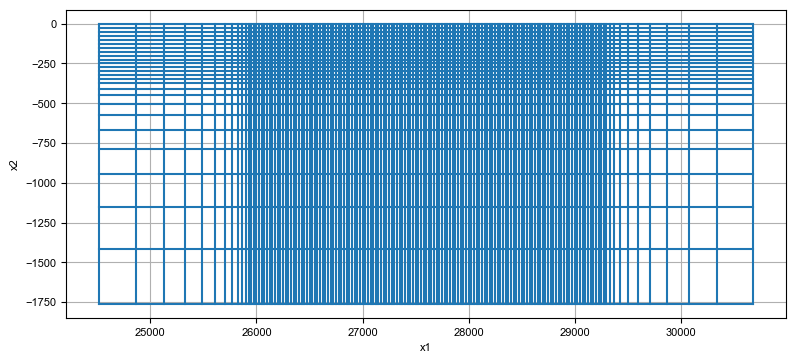

In [25]:
if verbose:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    mesh.plotGrid(ax=ax)
    ax.set_aspect(1.5)

### 3.2: Construct the forward simulation

A `simulation` object contains everything we need to compute potentials given a resistivity model. It is instantiated with:

- `mesh`: which discretizes the world and provides us with all of the differential operators


- `rhoMap`: in SimPEG, the `maps` module provides flexibility for defining what our inversion model is. Each `Map` is a mathematical transform (that has a derivative - which we need in the inversion!). For example, the `ExpMap` takes the exponential of a model vector; we would define our model as log-resistivity. This is useful in electrical and electromagnetic inversions where we know that electrical resistivity should be strictly positive, and tends to vary logarithmically. 
<img src="https://gpg.geosci.xyz/_images/resistivity_table.png" width=70%>
  Similarly, mappings can be used to define active and inactive cells (for example if we have topography and don't want to invert for air-cells), or to define parametric models. 
  

- `solver`: A linear solver (e.g. LU) provided in the [pymatsolver repository](https://pymatsolver.readthedocs.io/en/latest/). Here we use Pardiso. 


- `storeJ`: for smaller problems, where we aren't memory limited, the inversion is faster if we store the sensitivity matrix rather than 

In [26]:
# forward simulation 
# Use Exponential Map: m = log(rho)
mapping = maps.ExpMap(mesh)

# Generate 2.5D DC problem
simulation_dc = dc.Simulation2DNodal(
    mesh, rhoMap=mapping, solver=Solver, survey=survey, storeJ=True
)

To check our mesh and forward simulation, we run a simulation over a half-space. The apparent resistivities we compute from the simulated data should be equal to the true half-space resistivity. 

In [27]:
%%time 

# run the forward simulation over the half-space & plot apparent resistivities
m0 = np.ones(mesh.nC) * np.log(rho0)
d0 = simulation_dc.make_synthetic_data(m0)

CPU times: total: 3.45 s
Wall time: 3.2 s


C:\Users\dwill\AppData\Local\Temp\ipykernel_27768\2524136534.py:6: UserWarning: plot_pseudosection unused kwargs: ['data_location']
  dc_utils.plot_pseudosection(


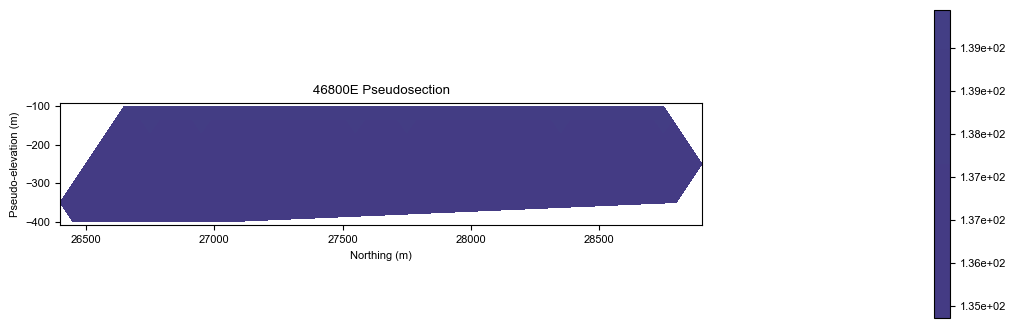

In [28]:
if verbose:
    # plot psuedosection
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))

    clim = np.r_[apparent_resistivity.min(), apparent_resistivity.max()]
    dc_utils.plot_pseudosection(
        d0, data_type="apparent resistivity",  clim=clim,
        plot_type="contourf", data_location=True, ax=ax, 
        cbar_opts={"pad":0.25}
    )
    ax.set_aspect(1.5)  # some vertical exxageration
    ax.set_title(f"{line} Pseudosection")
    ax.set_xlabel("Northing (m)")

This next plot shows the percent error in the apparent resistivity. We want the error to be less than the errors in our data: 5% is common for assigning a percent uncertainty, so if the errors are below that, then we can be satisfied with our setup. If not, there are several things to check. In general (for nearly every geophysical survey):
- boundary conditions - does the mesh extend far enough?
- discretization near source and receivers - are we using fine-enough cells
- specifically for 2.5 DC: are we using enough filters (we will revisit this in the next notebook) 

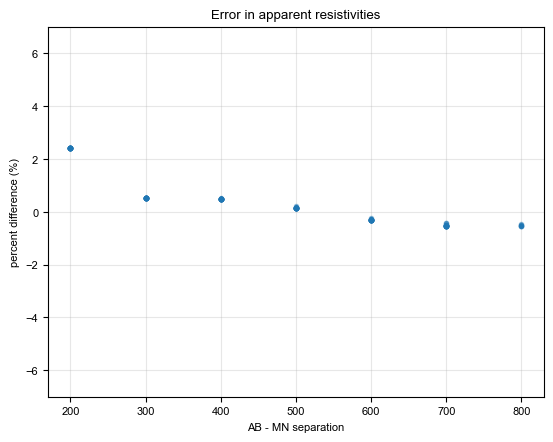

In [29]:
apparent_resistivity_m0 = dc_utils.apparent_resistivity_from_voltage(d0.survey, d0.dobs)
percent_error = (apparent_resistivity_m0 - rho0)/rho0*100

if verbose:
    fig, ax = plt.subplots(1, 1)
    ax.plot(separation_ab_mn[:, 0], percent_error, '.', alpha=0.4)
    ax.set_xlabel("AB - MN separation")
    ax.set_ylabel("percent difference (%)")
    ax.set_title("Error in apparent resistivities")
    ax.set_ylim(7*np.r_[-1, 1])
    ax.grid(alpha=0.3)

# 4. DC resistivity inversion

We formulate the inverse problem as an optimization problem consisting of a data misfit and a regularization 

$$
\displaylines{\min_{\mathbf{m}} \Phi(\mathbf{m}) = \Phi_d(\mathbf{m}) + \beta\Phi_m(\mathbf{m}) \\
s.t. ~ \Phi_d \leq \Phi_d^* \quad \mathbf{m}_i^{\rm L} \leq \mathbf{m} \leq \mathbf{m}_i^{\rm U}}
$$

where:
- $\mathbf{m}$ is our inversion model - a vector containing the set of parameters that we invert for
- $\Phi_d$ is the data misfit
- $\Phi_m$ is the regularization
- $\beta$ is a trade-off parameter that weights the relative importance of the data misfit and regularization terms
- $\Phi_d^*$ is our target misfit, which is typically set to $N/2$ where $N$ is the number of data (Parker, 1994) (or also see [Oldenburg & Li (2005)](https://www.researchgate.net/profile/Douglas_Oldenburg/publication/238708196_5_Inversion_for_Applied_Geophysics_A_Tutorial/links/004635282572529927000000.pdf))

### 4.1 Data Misfit

The data misfit, $\Phi_d(\mathbf{m})$, is often taken to be a weighted $\ell_2$-norm, where the weights capture the noise model (eg. we want to assign higher weights and do a good job fitting data that we are confident are less noisy, and assign less weight / influence to data that are noisy). The $\ell_2$ norm is the correct norm to choose when noise is Gaussian (or approximately Gaussian, or if you have no additional information and assume it is Gaussian). An $\ell_2$ data misfit is captured mathematically by  

$$
\Phi_d(\mathbf{m}) = \frac{1}{2}\|\mathbf{W_d} (\mathcal{F}(\mathbf{m}) - \mathbf{d}^{\text{obs}})\|^2
$$

where 

- $\mathbf{W_d} = \text{diag}(1/\boldsymbol{\epsilon})$ is a diagonal matrix with diagonal entries $1/\epsilon_i$, where $\epsilon_i$ is an estimated standard deviation of the $i$th datum.
- $\mathcal{F}$ is the forward modelling operator that simulates predicted data given a model
- $\mathbf{d}^{\text{obs}}$ is the observed data

To instantiate the data misfit term, we provide a `data` object (which also has the associated uncertainties) along with a `simulation` which has the machinery to compute predicted data. 

In [30]:
# set up the data misfit
dmisfit = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation_dc)

### 4.2 Regularization
The inverse problem is an [ill posed problem](https://en.wikipedia.org/wiki/Well-posed_problem). There are multiple (actually infinitely many!) models that can fit the data.  If we start by thinking about a linear problem $\mathbf{G}\mathbf{m} = \mathbf{d}$, the matrix $\mathbf{G}$ has more columns than rows, so it is not directly invertible (eg. see Matt Hall's [Linear Inversion Tutorial](http://library.seg.org/doi/full/10.1190/tle35121085.1)). Here, we are dealing with a non-linear system of equations, but the principle is the same. 

Thus, to choose from the infinitely many solutions and arrive at a sensible one, we employ a regularization: $\Phi_m$. Tikhonov regularization, which again uses $\ell_2$-norms, is a standard choice (It has a few nice features: it is convex and easy to differentiate). It takes the form: 
$$
\Phi_m(\mathbf{m}) = \frac{1}{2}\big(\alpha_s\|\mathbf{W_s} (\mathbf{m} - \mathbf{m}_{\text{ref}})\|^2 + \alpha_x\|\mathbf{W_x} (\mathbf{m})\|^2 + \alpha_z\|\mathbf{W_z} (\mathbf{m})\|^2 \big)
$$


The first term is often referred to as the "smallness" as it measures the "size" of the model (in the $\ell_2$ sense). The matrix $\mathbf{W_s}$ is generally taken to be a diagonal matrix that may contain information about the length scales of the model or be used to weight the relative importance of various parameters in the model. The scalar $\alpha_s$ weights the relative importance of this term in the regularization. 

Notice that we include a reference model ($\mathbf{m}_{\text{ref}}$). Often this is defined as a constant value, but if more information is known about the background, that can be used to construct a reference model. Note that saying "I am not going to use a reference model" means that you are actually using $\mathbf{m}_{\text{ref}} = 0$, this is important to realize... in the inversion we demonstrate here, our `model` will be $\mathbf{m} = \text{log}(\rho)$. If we set $\mathbf{m}_{\text{ref}} = 0$, then we are favoring models close to 1 $\Omega$m - which is quite conductive! 

The second term is often referred to as the "smoothness". The matrix $\mathbf{W_{\{x, z\}}}$ approximate the derivative of the model with respect to depth, and is hence a measure of how "smooth" the model is. The term $\alpha_{\{x,z\}}$ weights its relative importance in the regularization. 

The values $\alpha_x, \alpha_z$ have dimensions of $(length)$^2 as compared to $\alpha_s$. So if we choose our length scale to be 25m, the size of our finest cells and $\alpha_x = 1$, then we set $\alpha_s = 1/25^2$. In notebook [3-inversions-dc.ipynb](3-inversions-dc.ipynb). We will explore these choices further.  

In [31]:
# Related to inversion
mesh_hx = mesh.h[0]
reg = regularization.WeightedLeastSquares(
    mesh, 
    alpha_s=1./mesh_hx.min()**2,  # we will talk about these choices in notebook 3 on inversion
    alpha_x=1, 
    alpha_y=1,  # since this is a 2D problem, the second dimension is "y" 
)

Next, we assemble the data misfit and regularization into a statement of the inverse problem. We select an optimization method: in this case, a second-order Inexact Gauss Newton (see [Nocedal and Wright, Ch 7](https://link.springer.com/book/10.1007/978-0-387-40065-5)). The `inverse_problem` then has all of the machinery necessary to evaluate the objective function and compute an update.  

In [32]:
opt = optimization.InexactGaussNewton(maxIter=20, maxIterCG=20)
inv_prob = inverse_problem.BaseInvProblem(dmisfit, reg, opt)

### 4.3 Assemble the inversion

In SimPEG, we use `directives` to orchestrate updates during the inversion. The three we use below are

- `betaest`: sets an initial value for $\beta$ by estimating the largest eigenvalue of  $\Phi_d$ and of $\Phi_m$ and then taking their ratio. The value is then scaled by the `beta0_ratio` value, so for example if you wanted the regularization to be ~10 times more important than the data misfit, then we would set `beta0_ratio=10`


- `beta_schedule`: this reduces the value of beta during the course of the inversion. Particularly for non-linear problems, it can be advantageous to start off by seeking a smooth model which fits the regularization and gradually decreasing the influence of the regularization to increase the influence of the data. 


- `target`: this directive checks at the end of each iteration if we have reached the target misfit. If we have, the inversion terminates, if not, it continues. 


In [33]:
# directives
beta_est = directives.BetaEstimate_ByEig(beta0_ratio=1)

#coolFac = 4
coolFac = 1
beta_schedule = directives.BetaSchedule(coolingFactor=coolFac, coolingRate=2)
target = directives.TargetMisfit()

inv = inversion.BaseInversion(
    inv_prob, directiveList=[beta_est, beta_schedule, target]
)

### 4.4 Run the inversion!

In [34]:
# Run inversion
mopt = inv.run(m0)


Running inversion with SimPEG v0.23.1.dev10+gf697d2455
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.96e+00  1.83e+04  0.00e+00  1.83e+04    6.28e+03      0              
   1  6.96e+00  3.71e+03  1.00e+02  4.40e+03

In [35]:
# Save estimated resistivity
rho = (mapping*mopt)
np.save('rho_est_dc', rho)

C:\Users\dwill\AppData\Local\Temp\ipykernel_27768\94210697.py:12: UserWarning: plot_pseudosection unused kwargs: ['data_location']
  dc_utils.plot_pseudosection(


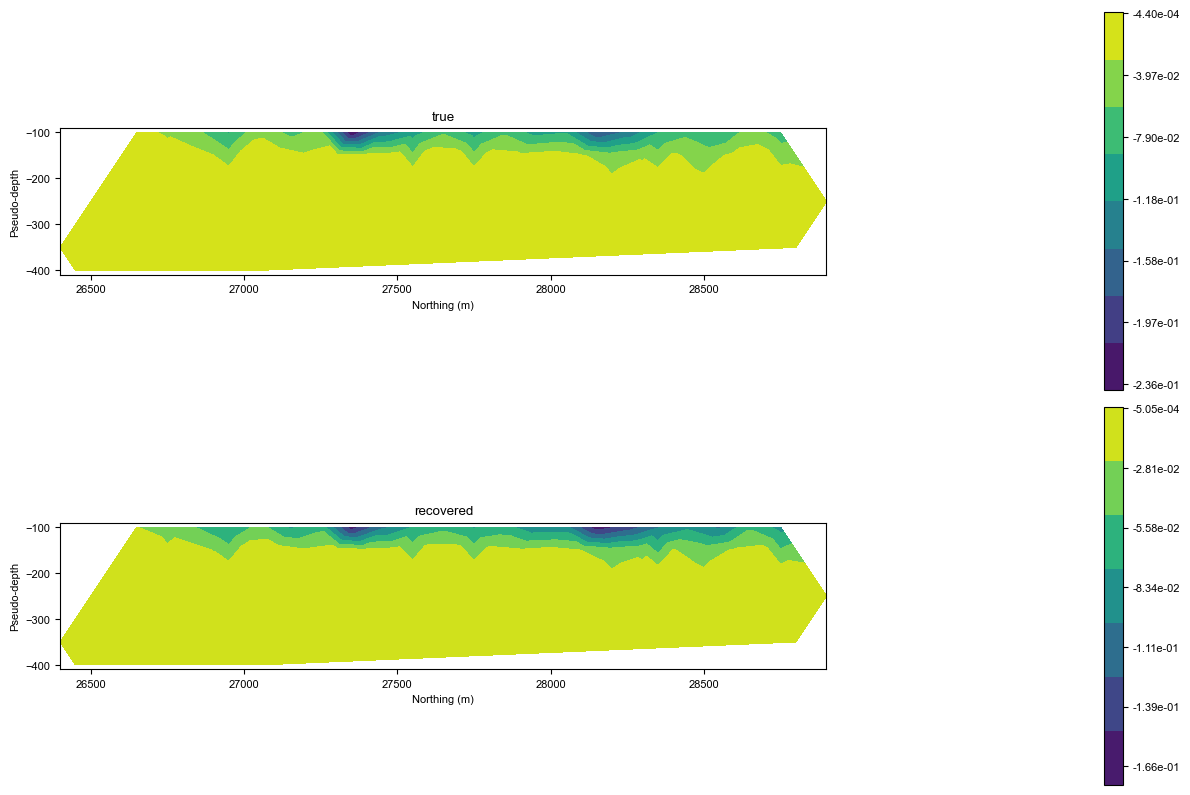

In [36]:
if verbose:
    # plot pseudosection
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    clim = np.r_[apparent_resistivity.min(), apparent_resistivity.max()]

    for a, data, title in zip(
        ax,
        [dc_data.dobs, inv_prob.dpred],
        ["true", "recovered"]
        ): 
        dc_utils.plot_pseudosection(
            dc_data, dobs=data, data_type="apparent resistivity",
            plot_type="contourf", data_location=True, ax=a, 
            cbar_opts={"pad":0.25}#, clim=clim
        )
        a.set_title(title)

    for a in ax: 
        a.set_aspect(1.5)  # some vertical exxageration
        a.set_xlabel("Northing (m)")
        a.set_ylabel("Pseudo-depth")

    plt.tight_layout()



C:\Users\dwill\AppData\Local\Temp\ipykernel_27768\2500391672.py:7: UserWarning: plot_pseudosection unused kwargs: ['data_location']
  dc_utils.plot_pseudosection(


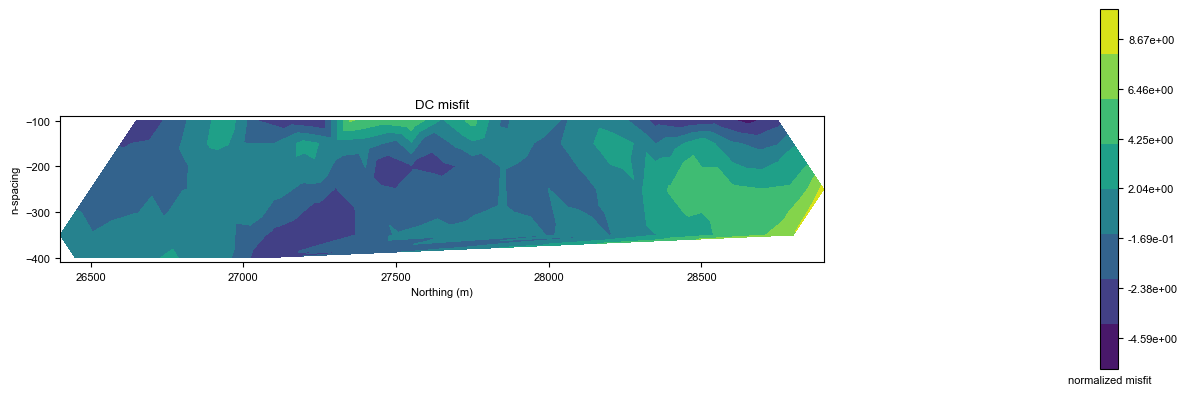

In [37]:
if verbose:
    # plot misfit
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))

    normalized_misfit = (inv_prob.dpred - dc_data.dobs) / dc_data.standard_deviation

    dc_utils.plot_pseudosection(
        dc_data, dobs=normalized_misfit, data_type="misfit",
        plot_type="contourf", data_location=True, ax=ax, 
        cbar_opts={"pad":0.25}
    )

    ax.set_title("DC misfit")
    ax.set_aspect(1.5)  # some vertical exxageration
    ax.set_xlabel("Northing (m)")
    ax.set_ylabel("n-spacing")

    cb_axes = plt.gcf().get_axes()[-1]
    cb_axes.set_xlabel('normalized misfit')

    plt.tight_layout()

In [38]:
# 
def load_leapfrog_geologic_section(filename="./century/geologic_section.csv"):
    """
    Load the geologic cross section. 
    """
    fid = open(filename, 'r')
    lines = fid.readlines()
    data = []
    data_tmp = []
    for line in lines[2:]:
        line_data = (line.split(',')[:3])
        if 'End' in line:
            data.append(np.vstack(data_tmp)[:,[0, 2]])
            data_tmp = []
        else:
            data_tmp.append(np.array(line_data, dtype=float))
    return data

In [39]:
geologic_section = load_leapfrog_geologic_section()

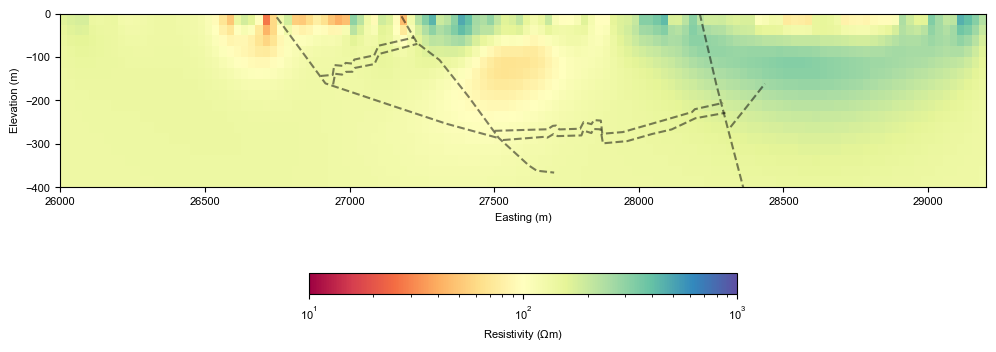

In [40]:
if verbose:
    fig, ax = plt.subplots(1,1, figsize=(10, 5))
    rho = (mapping*mopt)
    norm = LogNorm(vmin=1e1, vmax=1e3)
    #out = mesh.plotImage(
    #    rho, pcolor_opts={'norm':norm, 'cmap':'Spectral'}, ax=ax,
    #    clim=(30, 1000)
    #)
    out = mesh.plot_image(
        rho, pcolor_opts={'norm':norm, 'cmap':'Spectral'}, ax=ax
    )
    
    for data in geologic_section:
        ax.plot(data[:,0], data[:,1], 'k--', alpha=0.5)
    
    ax.set_xlim(core_domain_x)
    ax.set_ylim((-400, 0))
    cb = plt.colorbar(out[0], fraction=0.05, orientation='horizontal', ax=ax, pad=0.2)
    cb.set_label("Resistivity ($\Omega$m)")
    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Elevation (m)')
    ax.set_aspect(1.5)  # some vertical exxageration
    plt.tight_layout()

## Compare to UBC results obtained 20 years ago(!)

In [41]:
mesh_ubc = discretize.TensorMesh.read_UBC("century/46800E/468MESH.DAT")

In [42]:
def read_ubc_model(filename, mesh_ubc=mesh_ubc): 
    """
    A function to read a UBC conductivity or chargeability model. 
    """
    values = np.genfromtxt(
        filename, delimiter=' \n',
        dtype=str, comments='!', skip_header=1
    )
    tmp = np.hstack([np.array(value.split(), dtype=float) for value in values])
    model_ubc = discretize.utils.mkvc(tmp.reshape(mesh_ubc.vnC, order='F')[:,::-1])
    return model_ubc
    

In [43]:
sigma_ubc = read_ubc_model("century/46800E/DCMODA.CON")
rho_ubc = 1./sigma_ubc

C:\Users\dwill\AppData\Local\Temp\ipykernel_27768\3466810303.py:11: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  out = mesh.plotImage(
C:\Users\dwill\.conda\envs\simpeg-dev\Lib\site-packages\discretize\utils\code_utils.py:311: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)
C:\Users\dwill\AppData\Local\Temp\ipykernel_27768\3466810303.py:22: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  out = mesh_ubc.plotImage(


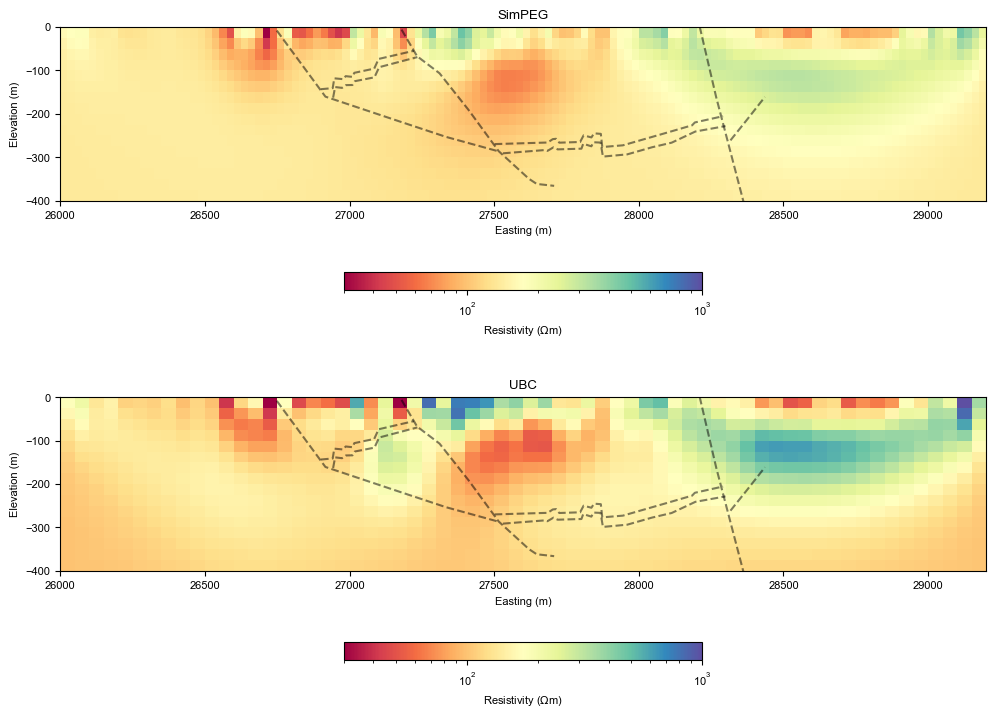

In [44]:
if verbose:
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    rho = (mapping*mopt)
    clim = (30, 1000)

    #out = mesh.plotImage(
    #    rho, pcolorOpts={'norm':LogNorm(), 'cmap':'Spectral'}, ax=ax[0],
    #    clim=clim 
    #)
    norm = LogNorm(vmin=clim[0], vmax=clim[1])
    out = mesh.plotImage(
        rho, pcolorOpts={'norm':norm, 'cmap':'Spectral'}, ax=ax[0] 
    )
    cb = plt.colorbar(out[0], fraction=0.05, orientation='horizontal', ax=ax[0], pad=0.2)
    cb.set_label("Resistivity ($\Omega$m)")
    ax[0].set_title("SimPEG")

    #out = mesh_ubc.plotImage(
    #    rho_ubc, pcolor_opts={'norm':LogNorm(), 'cmap':'Spectral'}, ax=ax[1],
    #    clim=clim 
    #)
    out = mesh_ubc.plotImage(
        rho_ubc, pcolor_opts={'norm':norm, 'cmap':'Spectral'}, ax=ax[1]
    )
    cb = plt.colorbar(out[0], fraction=0.05, orientation='horizontal', ax=ax[1], pad=0.2)
    cb.set_label("Resistivity ($\Omega$m)")
    ax[1].set_title("UBC")

    for a in ax: 
        for data in geologic_section:
            a.plot(data[:,0], data[:,1], 'k--', alpha=0.5)
        a.set_xlim(core_domain_x)
        a.set_ylim((-400, 0))
        a.set_aspect(1.5)  # some vertical exxageration
        a.set_xlabel('Easting (m)')
        a.set_ylabel('Elevation (m)')

    plt.tight_layout()

----
# Induced Polarization 

Induced Polarization (IP) surveys are sensitive to chargeability - the physical property which describes a material's tendency to become polarized and act like a capacitor. 

<img src="images/chargeability.png" width=30%>

The physical explanation for causes of chargeability are complex and are an active area of research. There are, however, two conceptual models that are insightful for characterizing the chargeable behaviour of rocks: membrane polarization and electrode polarization. 

<img src="images/conceptual-model-ip.png" width = 70%>

Physically, the presence of chargeable material causes the measured voltage to increase in the on-time, and after the current switch-off, the voltage decays. In the on-time, currents are primarily due to the potential difference made by a generator, and distorted by conductivity constrasts in the earth (DC-effects). In addition, polarization charges start to build, and reach steady state in the late on-time. After the current is switched off, all DC currents are immediately gone, but polarization charges remain and will start to discharge and generate a 
secondary voltage decay (IP). 

<img src="https://em.geosci.xyz/_images/DCIP.png" width=60%>

For more background information on IP, including case histories, see the [EM GeoSci pages on IP](https://em.geosci.xyz/content/geophysical_surveys/ip/index.html).


## IP simulation 

To simulate IP, we use a linearized model where we assume that the IP signals are due to a perturbation in electrical conductvity (inverse of resistivity) 

$$
\rho_\eta = \rho\frac{1}{1-\eta} \quad \eta \in [0, 1)
$$

with an IP datum written as 

$$
d_i^{IP} = \sum_{j=1}^M J_{ij}\eta_j \quad i = 1, ..., N
$$

where the entries of J are the sensitivities for the DC resistivity problem 

$$
J_{i,j} = \frac{\partial\log\phi^i}{\partial\log\rho_j}
$$

or in matrix form 

$$
\mathbf{d^{IP}} = \mathbf{J}\mathbf{\eta}
$$

For further discussion, see the [derivation here](https://em.geosci.xyz/content/geophysical_surveys/ip/interpretation.html#linearization)


## Step 5: Load the IP data

There are several ways to define IP data, for discussion, please see the [reference page on IP data in em.geosci.xyz](https://em.geosci.xyz/content/geophysical_surveys/ip/data.html). For this survey, the data that we are provided are apparent chargeabilities (mV/V). This is analagous to apparent resistivity that we discussed for DC resistivity. 

The file format and organization is identical to what we implemented for the DC data, so we can re-use that function to load our data into a dictionary. 

In [45]:
ip_data_file = f"./century/{line}/{line[:-1]}IP.OBS"

In [46]:
ip_data_dict = read_dcip_data(ip_data_file, verbose=False)

The organization of an IP survey is very similar to the DC case. Here, we are calling sources and receivers from the `ip` module, and also specifying that the receivers are measuring apparent chargeability data. 

In [47]:
# initialize an empty list for each 
source_list_ip = []

for i in range(ip_data_dict["n_sources"]):    
    # receiver electrode locations in 2D 
    m_locs = np.vstack([
        ip_data_dict["m_locations"][i], 
        np.zeros_like(ip_data_dict["m_locations"][i])
    ]).T
    n_locs = np.vstack([
        ip_data_dict["n_locations"][i],
        np.zeros_like(ip_data_dict["n_locations"][i])
    ]).T
    
    # construct the receiver object 
    receivers = ip.receivers.Dipole(
        locations_m=m_locs, locations_n=n_locs, data_type="apparent_chargeability"
    )
    
    # construct the source 
    source = ip.sources.Dipole(
        location_a=np.r_[ip_data_dict["a_locations"][i], 0.],
        location_b=np.r_[ip_data_dict["b_locations"][i], 0.],
        receiver_list=[receivers]
    )
    
    # append the new source to the source list
    source_list_ip.append(source)

In [48]:
survey_ip = ip.Survey(source_list_ip)

In [49]:
ip_data = Data(
    survey=survey, 
    dobs=np.hstack(ip_data_dict["observed_data"]), 
    standard_deviation=np.hstack(ip_data_dict["standard_deviations"])
)

C:\Users\dwill\AppData\Local\Temp\ipykernel_27768\2472597523.py:5: UserWarning: plot_pseudosection unused kwargs: ['data_location']
  dc_utils.plot_pseudosection(


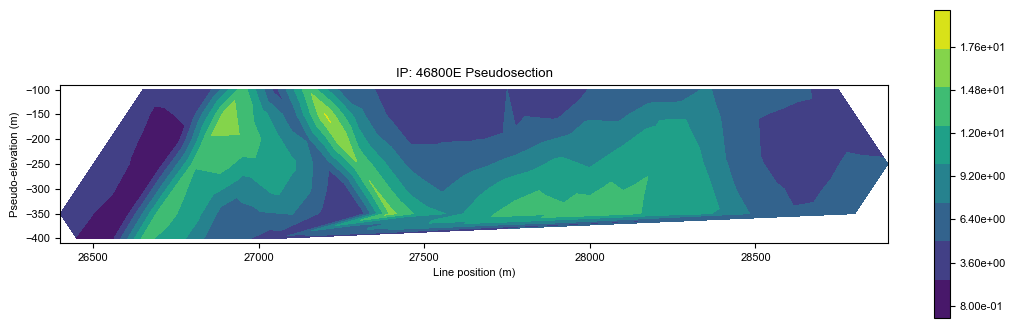

In [50]:
if verbose:
    # plot psuedosection
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    #ip.utils.
    dc_utils.plot_pseudosection(
        ip_data, data_type="apparent chargeability",
        plot_type="contourf", data_location=True, ax=ax, 
    )
    ax.set_title(f"IP: {line} Pseudosection")
    ax.set_aspect(1.5)  # some vertical exxageration

## Step 6: Define the IP simulation

The general setup of an IP simulation is very similar to what we saw earlier for DC. Now, instead of inverting for resistivity (`rho`), we invert for chargeability (`eta`). The only additional parameter that is needed is the electrical resistivity (`rho`) from the DC inversion. This is used to construct the forward operator in the linear model of IP as described in the [IP Simulation](#IP-simulation) section above. 

In [51]:
simulation_ip = ip.Simulation2DNodal(
    mesh=mesh, solver=Solver, rho=np.exp(mopt), 
    etaMap=maps.IdentityMap(mesh), survey=survey_ip,
    storeJ=True
)

## Step 7: IP inversion

The setup for the IP inversion is very similar to what we did earlier for DC. The only change you will notice is that for the optimization, we are now using `ProjectedGNCG`: this is a Projected Gauss Newton with Conjugate Gradient (an iterative solver) optimization routine. It is similar to Inexact Gauss Newton but allows bound contstraints to be imposed. Here, we know that apparent chargeability is positive, so we use a lower bound of zero. 

We do not use an `ExpMap` as we did for resistivity in the DC inversion because chargeability tends to vary on a linear scale. 

In [52]:
dmisfit_ip = data_misfit.L2DataMisfit(data=ip_data, simulation=simulation_ip)
mesh_hx = mesh.h[0]
mesh_hy = mesh.h[1]
# Related to inversion
reg_ip = regularization.WeightedLeastSquares(
    mesh,
    alpha_s=1/mesh_hx.min()**2.,
    alpha_x=1.,
    alpha_y=1.,
)

In [53]:
opt_ip = optimization.ProjectedGNCG(
    maxIter=20, maxIterCG=20, upper=np.inf, lower=0.
)

In [54]:
inv_prob_ip = inverse_problem.BaseInvProblem(dmisfit_ip, reg_ip, opt_ip)

**Set a small starting model** - this is often assumed to be zero (no chargeable material). Here, since we will be using bound constraints in the optimization, we use a small value to reduce challenges of "getting stuck" on the lower bound of zero. 

In [55]:
m0_ip =  1e-3 * np.ones(mesh.nC)

In [56]:
beta_est_ip = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
beta_schedule_ip = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
target_ip = directives.TargetMisfit()

inv_ip = inversion.BaseInversion(
    inv_prob_ip, directiveList=[beta_est_ip, beta_schedule_ip, target_ip]
)

In [57]:
# Run inversion
charge_opt = inv_ip.run(m0_ip)


Running inversion with SimPEG v0.23.1.dev10+gf697d2455
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.03e-02  8.90e+04  0.00e+00  8.90e+04    7.88e+02      0              
   1  3.52e-02  2.36e+03  9.22e+04  5.60e+03

C:\Users\dwill\AppData\Local\Temp\ipykernel_27768\3572630374.py:3: UserWarning: plot_pseudosection unused kwargs: ['data_location']
  dc_utils.plot_pseudosection(


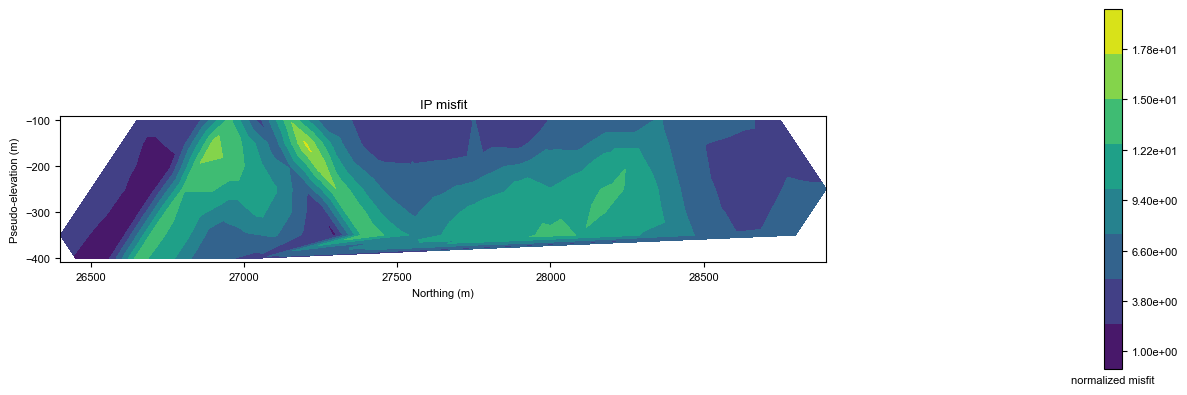

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

dc_utils.plot_pseudosection(
    ip_data, dobs=inv_prob_ip.dpred, data_type="apparent chargeability",
    plot_type="contourf", data_location=True, ax=ax, 
    cbar_opts={"pad":0.25}
)

ax.set_title("IP misfit")
ax.set_aspect(1.5)  # some vertical exxageration
ax.set_xlabel("Northing (m)")
cb_axes = plt.gcf().get_axes()[-1]
cb_axes.set_xlabel('normalized misfit')

plt.tight_layout()

C:\Users\dwill\AppData\Local\Temp\ipykernel_27768\3887622732.py:7: UserWarning: plot_pseudosection unused kwargs: ['data_location']
  dc_utils.plot_pseudosection(


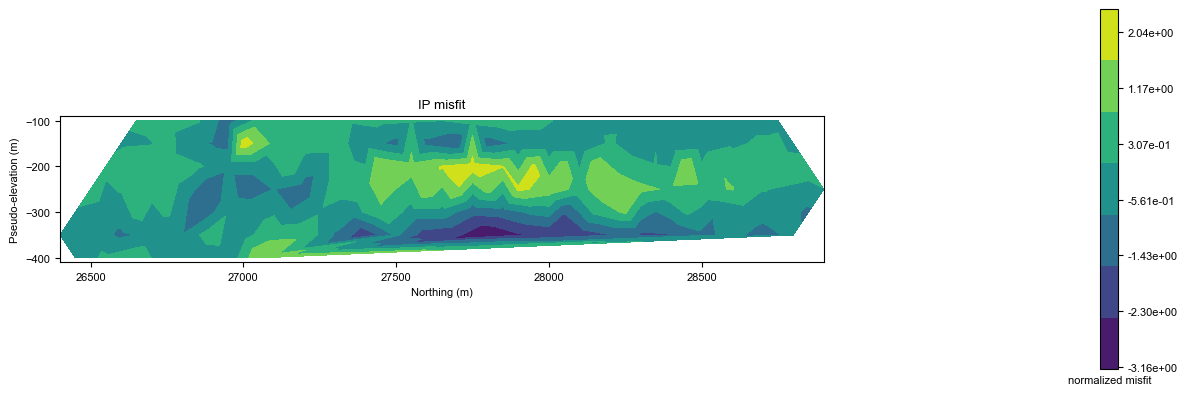

In [59]:
if verbose:
    # plot misfit
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))

    normalized_misfit = (inv_prob_ip.dpred - ip_data.dobs) / ip_data.standard_deviation

    dc_utils.plot_pseudosection(
        ip_data, dobs=normalized_misfit, data_type="misfit",
        plot_type="contourf", data_location=True, ax=ax, 
        cbar_opts={"pad":0.25}
    )

    ax.set_title("IP misfit")
    ax.set_aspect(1.5)  # some vertical exxageration
    ax.set_xlabel("Northing (m)")

    cb_axes = plt.gcf().get_axes()[-1]
    cb_axes.set_xlabel('normalized misfit')

    plt.tight_layout()

C:\Users\dwill\AppData\Local\Temp\ipykernel_27768\3001797600.py:3: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  out = mesh.plotImage(
C:\Users\dwill\.conda\envs\simpeg-dev\Lib\site-packages\discretize\utils\code_utils.py:311: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)


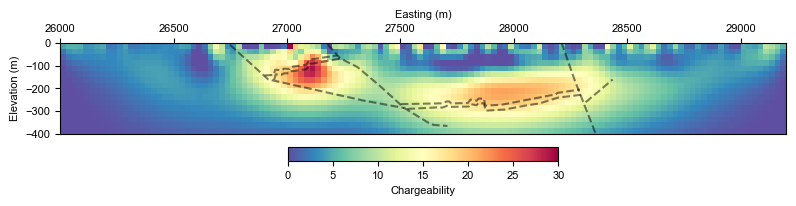

In [77]:
if verbose:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    out = mesh.plotImage(
        charge_opt,  
        pcolorOpts={'cmap':'Spectral_r'}, ax=ax,
        clim=(0, 30)
    )
    for data in geologic_section:
        ax.plot(data[:,0], data[:,1], 'k--', alpha=0.5)

    cb = plt.colorbar(out[0], fraction=0.025, 
                  orientation='horizontal', 
                  ax=ax, pad=0.025)
    cb.set_label("Chargeability")

    ax.set_xlim(core_domain_x)
    ax.set_ylim(-400, 0)
    ax.set_aspect(2)  # some vertical exxageration
    ax.set_xlabel('Easting (m)', loc = "center")
    ax.set_ylabel('Elevation (m)')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_aspect(1)
    plt.tight_layout()

    plt.savefig('century_sol_simpeg.png', dpi=300, bbox_inches='tight')

In [ ]:
charge_ubc = read_ubc_model("century/46800E/IPMODA.CHG")

In [ ]:
if verbose:
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    rho = (mapping*mopt)
    clim = (0, 30)

    out = mesh.plotImage(
        charge_opt, pcolorOpts={'cmap':'Spectral_r'}, ax=ax[0],
        clim=clim
    )
    cb = plt.colorbar(out[0], label="Chargeability", fraction=0.05, orientation='horizontal', ax=ax[0], pad=0.2)
    ax[0].set_title("SimPEG")

    out = mesh_ubc.plotImage(
        charge_ubc, pcolorOpts={'cmap':'Spectral_r'}, ax=ax[1],
        clim=clim
    )
    cb = plt.colorbar(out[0], label="Chargeability", fraction=0.05, orientation='horizontal', ax=ax[1], pad=0.2)
    ax[1].set_title("UBC")

    for a in ax: 
        for data in geologic_section:
            a.plot(data[:,0], data[:,1], 'k--', alpha=0.5)
        
        a.set_xlim(core_domain_x)
        a.set_ylim((-400, 0))
        a.set_aspect(1.5)
        a.set_xlabel('Easting (m)')
        a.set_ylabel('Elevation (m)')
    
    plt.tight_layout()



## Homework ✏️

There are 6 lines of data in total for the century deposit. Can you invert them all? 

Send us images of your results on Slack! We will share images of the UBC results in 1 week. 

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
dc_utils.plot_pseudosection(
    ip_data, data_type="apparent chargeability",
    plot_type="contourf", data_location=True, ax=ax,
)
ax.set_title(f"IP: {line} Pseudosection")
ax.set_aspect(1.5)  # some vertical exxageration